In [57]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
warnings.filterwarnings('ignore')

%matplotlib inline

In [58]:
criteria_name = 'beh_low'

In [59]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
    
with open(os.path.join('/root/capsule/scratch/combined/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

In [60]:
for col, cfg in constraints.items():
    if col not in combined_tagged_units.columns:
        continue

    # Numeric range?
    if "bounds" in cfg:
        print(f'Applying bounds for {col}: {cfg["bounds"]}')
        lb, ub = np.array(cfg["bounds"], dtype=float)  # np.nan for null
        if not np.isnan(lb):
            mask &= combined_tagged_units[col] >= lb
        if not np.isnan(ub):
            mask &= combined_tagged_units[col] <= ub

    # Categorical list?
    elif "items" in cfg:
        print(f'Applying items for {col}: {cfg["items"]}')
        allowed = cfg["items"]
        mask &= combined_tagged_units[col].isin(allowed)

# apply and get filtered DataFrame
combined_tagged_units_filtered = combined_tagged_units[mask].reset_index(drop=True)
combined_tagged_units['selected'] = mask
print(f'Number of units after filtering: {len(combined_tagged_units_filtered)}')
# Save the filtered units
with open(os.path.join(beh_folder, f'filtered_units_{criteria_name}.pkl'), 'wb') as f:
    pickle.dump(combined_tagged_units_filtered, f)


Applying bounds for isi_violations: [0.0, 0.5]
Applying bounds for p_max: [0.5, 1.0]
Applying bounds for lat_max_p: [0.005, 0.02]
Applying bounds for eu: [0.0, 0.25]
Applying bounds for corr: [0.95, 1.0]
Applying items for qc_pass: [True]
Applying bounds for peak: [-1000, 0]
Applying bounds for trial_count: [100, 2000]
Applying items for in_df: [True]
Number of units after filtering: 147


In [61]:
def regressors_to_formula(response_var, regressors):
    terms = [r for r in regressors if r != 'Intercept']
    has_intercept = 'Intercept' in regressors
    rhs = '1' if has_intercept else '0'
    if terms:
        rhs += ' + ' + ' + '.join(terms)
    return f'{response_var} ~ {rhs}'

In [62]:
# get all t-stats, coeffs, p-values for the two groups
# grab all tagged units and combine spike waveforms
data_type = 'curated'
target = 'soma'
all_coefs = []
all_T = []
all_p = []
align_name = 'go_cue'
regressors_focus = ['Qchosen', 'ipsi', 'lick_lat']
regressors_sup = ['Intercept', 'amp', 'motion']
all_regressors = regressors_focus + regressors_sup
formula = regressors_to_formula('spikes', all_regressors)

curr_session = None
pre_event = -1.5
post_event = 3
model_name = 'stan_qLearning_5params'
binSize = 0.5
loaded_session = None
for ind, row in combined_tagged_units_filtered.iterrows():
    session = row['session']
    unit_id = row['unit']
    # check if different session
    if loaded_session is None or curr_session != session:
        session_dir = session_dirs(session)
        unit_tbl = get_unit_tbl(session, data_type)
        session_df = makeSessionDF(session, model_name = model_name)
        session_df['ipsi'] = 2*(session_df['choice'].values - 0.5) * row['rec_side']
        drift_data = load_trial_drift(session, data_type)
        loaded_session = session
    unit_drift = load_drift(session, unit_id, data_type=data_type)
    spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
    session_df_curr = session_df.copy()
    spike_times_curr = spike_times.copy()
    unit_trial_drift_curr = drift_data.load_unit(unit_id)
    # tblTrials_curr = tblTrials.copy()
    if unit_drift is not None:
        if unit_drift['ephys_cut'][0] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
        if unit_drift['ephys_cut'][1] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
    if 'amp_abs' in all_regressors or 'amp' in all_regressors:
        # get unit_trial_drift_curr's rows corresponding to the ones in session_df_curr
        session_df_curr = session_df_curr.merge(unit_trial_drift_curr, on='trial_ind', how='left').copy()
    if align_name == 'go_cue':
        align_time = session_df_curr['go_cue_time'].values
        # align_time_all = tblTrials_curr['goCue_start_time'].values
    elif align_name == 'response':
        align_time = session_df_curr['choice_time'].values
        # align_time_all = tblTrials_curr['reward_outcome_time'].values
    # spike_matrix, slide_times = get_spike_matrix(spike_times_curr, align_time, 
    #                                             pre_event=pre_event, post_event=post_event, 
    #                                             binSize=binSize, stepSize=stepSize)
    spike_matrix_LM, slide_times_LM = get_spike_matrix(spike_times_curr, align_time, 
                                                pre_event=pre_event, post_event=post_event, 
                                                binSize=binSize, stepSize=0.25)
    # spike_matrix_all, slide_times = get_spike_matrix(spike_times_curr, align_time_all, 
    #                                             pre_event=pre_event, post_event=post_event, 
    #                                             binSize=binSize, stepSize=stepSize)
    spike_matrix_LM = zscore(spike_matrix_LM, axis=0)  
    
        
    # try:
    regressors, curr_T, curr_p, curr_coefs = fitSpikeModelG(session_df_curr, spike_matrix_LM, formula)
    # pick regressors from regressors_focus list, sort them according to sequence in regressors_focus
    focus_ind = [regressors.index(r) for r in regressors_focus if r in regressors]
    curr_T = [T_t[focus_ind] for T_t in curr_T]
    curr_p = [p_t[focus_ind] for p_t in curr_p]
    curr_coefs = [coef_t[focus_ind] for coef_t in curr_coefs] 

    if len(curr_T) == 4:
        print(f'Session: {session}, Unit: {unit_id}') 

    all_coefs.append(curr_coefs)
    all_T.append(curr_T)
    all_p.append(curr_p)

In [63]:
all_coefsm = np.array(all_coefs)
all_Tm = np.array(all_T)
all_pm = np.array(all_p)

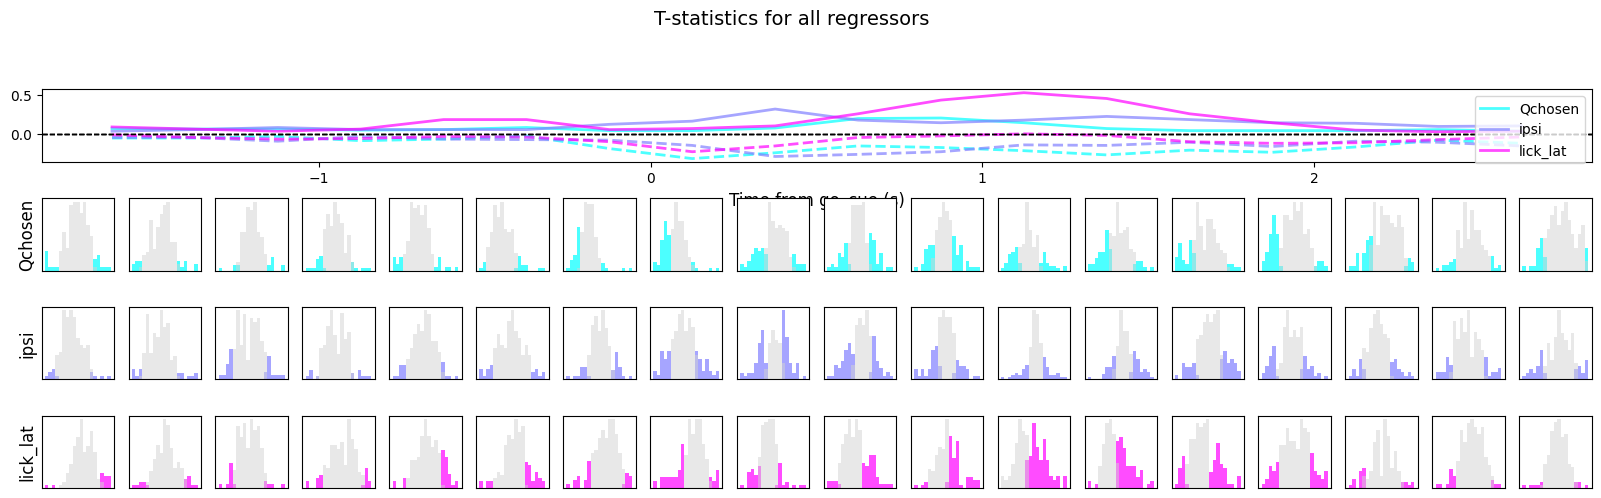

In [64]:
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(len(regressors_focus)+3, len(slide_times_LM), figure=fig, hspace=0.5)
cmap = plt.cm.cool  # Get the colormap
colors = cmap(np.linspace(0, 1, len(regressors_focus)))
ax_all = fig.add_subplot(gs[0, :]) 
for reg_ind, regressor in enumerate(regressors_focus):
    for time_ind, time in enumerate(slide_times_LM):
        ax = fig.add_subplot(gs[reg_ind+1, time_ind])
        curr_Ts = all_Tm[:, time_ind, reg_ind]  # get the T-statistics for the current regressor and time
        curr_Ps = all_pm[:, time_ind, reg_ind]  # get the p-values for the current regressor and time
        bins = np.linspace(np.nanmin(curr_Ts)-0.01, np.nanmax(curr_Ts)+0.01, 20)
        ax.hist(curr_Ts[curr_Ps<0.05], bins=bins, color=colors[reg_ind], alpha=0.7, edgecolor='none')  # plot T-statistics with p<0.05
        ax.hist(curr_Ts[curr_Ps>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
        if time_ind == 0:
            ax.set_ylabel(f'{regressor}', fontsize=12)
        # turn off y-ticks and x-ticks
        ax.set_yticks([])
        ax.set_xticks([])

    curr_Ps = np.squeeze(all_pm[:, :, reg_ind])
    curr_Ts = all_Tm[:, :, reg_ind]
    # check if any p-values are below 0.05
    curr_Ps_sig_pos = np.nanmean((curr_Ps<0.05)&(curr_Ts>0), axis = 0) 
    curr_Ps_sig_neg = -np.nanmean((curr_Ps<0.05)&(curr_Ts<0), axis = 0)   
    ax_all.plot(slide_times_LM, curr_Ps_sig_pos, color=colors[reg_ind], alpha=0.7, linewidth=2, label=regressor)  # plot the proportion of significant p-values over time
    ax_all.plot(slide_times_LM, curr_Ps_sig_neg, color=colors[reg_ind], alpha=0.7, linewidth=2, linestyle='--')  # plot the proportion of significant p-values over time
    ax_all.legend(loc='upper right', fontsize=10)
    ax_all.set_xlabel(f'Time from {align_name} (s)', fontsize=12)
    ax_all.axhline(0, color='k', linestyle='--', linewidth=1)  # add a horizontal line at y=0

plt.suptitle('T-statistics for all regressors', fontsize=14)
plt.savefig(os.path.join(beh_folder, f'Regression_in_time_{criteria_name}_{align_name}.pdf'), bbox_inches='tight')


In [65]:
import pandas as pd
import statsmodels.api as sm

def stepwise_glm(X, y, forced_vars, candidate_vars, criterion='aic', verbose=True):
    """
    Perform stepwise regression (GLM) with forced inclusion of some variables.

    Parameters:
    - X: DataFrame of all regressors
    - y: target variable (Series)
    - forced_vars: list of variables to always include
    - candidate_vars: list of variables to select from
    - criterion: 'aic' or 'bic'
    - verbose: whether to print step info

    Returns:
    - final_model: fitted statsmodels GLM
    - selected_vars: list of all variables in final model
    """
    
    def get_score(X_design, y_target):
        model = sm.GLM(y_target, sm.add_constant(X_design)).fit()
        score = model.aic if criterion == 'aic' else model.bic
        return score, model

    included = forced_vars.copy()
    optional = candidate_vars.copy()
    
    current_X = X[forced_vars].copy()
    best_score, best_model = get_score(current_X, y)

    changed = True
    while changed:
        changed = False

        # Try adding one variable
        scores_with_addition = []
        for var in optional:
            if var not in included:
                X_try = X[included + [var]]
                score, _ = get_score(X_try, y)
                scores_with_addition.append((score, var))
        scores_with_addition.sort()
        if scores_with_addition:
            best_new_score, best_var = scores_with_addition[0]
            if best_new_score < best_score:
                included.append(best_var)
                optional.remove(best_var)
                best_score = best_new_score
                changed = True
                if verbose:
                    print(f'Added: {best_var}, {criterion.upper()}: {best_score:.2f}')

        # Try removing one variable (not from forced)
        scores_with_removal = []
        for var in included:
            if var not in forced_vars:
                X_try = X[[v for v in included if v != var]]
                score, _ = get_score(X_try, y)
                scores_with_removal.append((score, var))
        scores_with_removal.sort()
        if scores_with_removal:
            best_new_score, worst_var = scores_with_removal[0]
            if best_new_score < best_score:
                included.remove(worst_var)
                optional.append(worst_var)
                best_score = best_new_score
                changed = True
                if verbose:
                    print(f'Removed: {worst_var}, {criterion.upper()}: {best_score:.2f}')

    final_model = sm.GLM(y, sm.add_constant(X[included])).fit()
    R2_final = r2_score(y, final_model.fittedvalues)
    forced_model = sm.GLM(y, sm.add_constant(X[forced_vars])).fit()
    R2_forced = r2_score(y, forced_model.fittedvalues)
    
    return forced_model, final_model, included, R2_final, R2_forced

def add_interactions(df, interaction_pairs):
    for var1, var2 in interaction_pairs:
        name = f"{var1}:{var2}"
        df[name] = df[var1] * df[var2]
    return df


In [66]:
# regression for go_cue window
regressors_focus_go = ['Qchosen', 'ipsi', 'lick_lat']
regressors_sup_go = ['amp', 'motion']

sig_regressors_go = pd.DataFrame(columns=['session', 'unit_id'] + regressors_focus_go + regressors_sup_go)
sig_regressors_go['session'] = combined_tagged_units_filtered['session']
sig_regressors_go['unit_id'] = combined_tagged_units_filtered['unit']
sig_regressors_go[regressors_focus_go] = 1
sig_regressors_go[regressors_sup_go] = 0
sig_regressors_go['R2_final'] = 0
sig_regressors_go['R2_forced'] = 0

t_regressors_go = pd.DataFrame(columns=['session', 'unit_id'] + regressors_focus_go)
t_regressors_go['session'] = combined_tagged_units_filtered['session']
t_regressors_go['unit_id'] = combined_tagged_units_filtered['unit']

t_regressors_motion_go = pd.DataFrame(columns=['session', 'unit_id'] + regressors_focus_go)
t_regressors_motion_go['session'] = combined_tagged_units_filtered['session']
t_regressors_motion_go['unit_id'] = combined_tagged_units_filtered['unit']

p_regressors_motion_go = t_regressors_motion_go.copy()
coefs_regressors_motion_go = t_regressors_motion_go.copy()

align_name = 'go_cue'
all_regressors = regressors_focus_go + regressors_sup_go
formula = regressors_to_formula('spikes', all_regressors)

for ind, row in combined_tagged_units_filtered.iterrows():
    session = row['session']
    unit_id = row['unit']
    if loaded_session is None or curr_session != session:
        session_dir = session_dirs(session)
        unit_tbl = get_unit_tbl(session, data_type)
        session_df = makeSessionDF(session, model_name=model_name)
        session_df['ipsi'] = 2 * (session_df['choice'].values - 0.5) * row['rec_side']
        drift_data = load_trial_drift(session, data_type)
        loaded_session = session

    unit_drift = load_drift(session, unit_id, data_type=data_type)
    spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
    session_df_curr = session_df.copy()
    spike_times_curr = spike_times.copy()
    unit_trial_drift_curr = drift_data.load_unit(unit_id)

    if unit_drift is not None:
        if unit_drift['ephys_cut'][0] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
        if unit_drift['ephys_cut'][1] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]

    if 'amp_abs' in all_regressors or 'amp' in all_regressors:
        session_df_curr = session_df_curr.merge(unit_trial_drift_curr, on='trial_ind', how='left').copy()

    for interaction in all_regressors:
        if ':' in interaction:
            reg1, reg2 = interaction.split(':')
            session_df_curr[interaction] = session_df_curr[reg1] * session_df_curr[reg2]

    align_time = session_df_curr['go_cue_time'].values
    spike_df = align.to_events(spike_times_curr, align_time, [0, binSize], return_df=True)
    counts = spike_df.groupby('event_index').size()
    counts = [counts.get(i, 0) for i in range(len(session_df_curr))]
    # baseline_df = align.to_events(spike_times_curr, align_time_cue, [-1, 0], return_df=True)
    # counts_bl = baseline_df.groupby('event_index').size()
    # counts_bl = [counts_bl.get(i, 0) for i in range(len(session_df_curr))]
    spike_matrix_LM = np.reshape(np.array([counts]), (-1, 1))
    spike_matrix_LM = zscore(spike_matrix_LM, axis=0)

    model_ori, model_final, included_regressors, R2_final_curr, R2_forced_curr = stepwise_glm(
        session_df_curr,
        spike_matrix_LM.flatten(),
        regressors_focus_go,
        regressors_sup_go,
        verbose=False,
        criterion='bic'
    )

    sig_regressors_go.loc[ind, included_regressors] = 1
    sig_regressors_go.loc[ind, 'R2_final'] = R2_final_curr
    sig_regressors_go.loc[ind, 'R2_forced'] = R2_forced_curr

    for regressor in regressors_focus_go:
        t_regressors_go.loc[ind, regressor] = model_ori.tvalues[regressor]
        t_regressors_motion_go.loc[ind, regressor] = model_final.tvalues[regressor]
        p_regressors_motion_go.loc[ind, regressor] = model_final.pvalues[regressor]
        coefs_regressors_motion_go.loc[ind, regressor] = model_final.params[regressor]


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Qchosen'),
  Text(1, 0, 'ipsi'),
  Text(2, 0, 'lick_lat'),
  Text(3, 0, 'amp'),
  Text(4, 0, 'motion')])

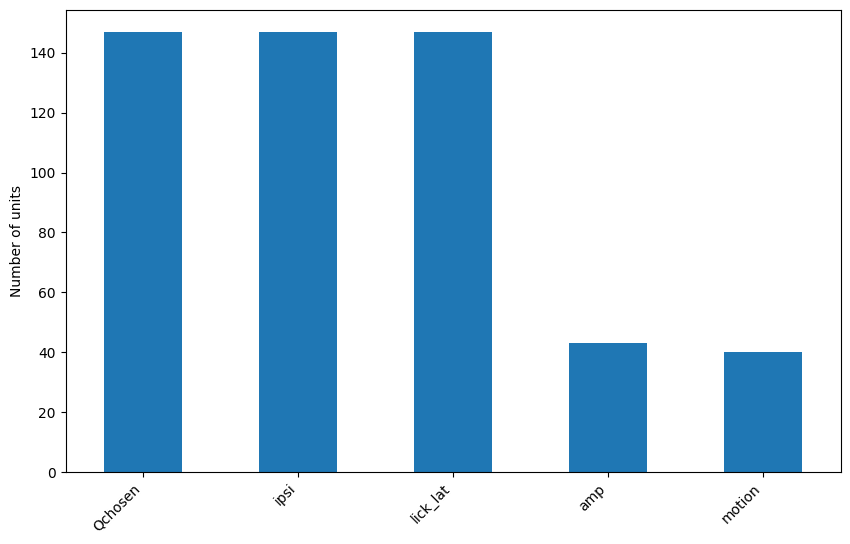

In [67]:
# plot bar plot for each column of sig_regressors
sig_regressors_plot = sig_regressors_go.drop(columns=['session', 'unit_id'])
sig_regressors_plot = sig_regressors_plot.astype(int)
sig_regressors_plot = sig_regressors_plot.sum(axis=0)
sig_regressors_plot = sig_regressors_plot[sig_regressors_plot > 0]
fig, ax = plt.subplots(figsize=(10, 6))
sig_regressors_plot.plot(kind='bar', ax=ax)
ax.set_ylabel('Number of units')
# change xaxis labels to 45 degree
plt.xticks(rotation=45, ha='right')


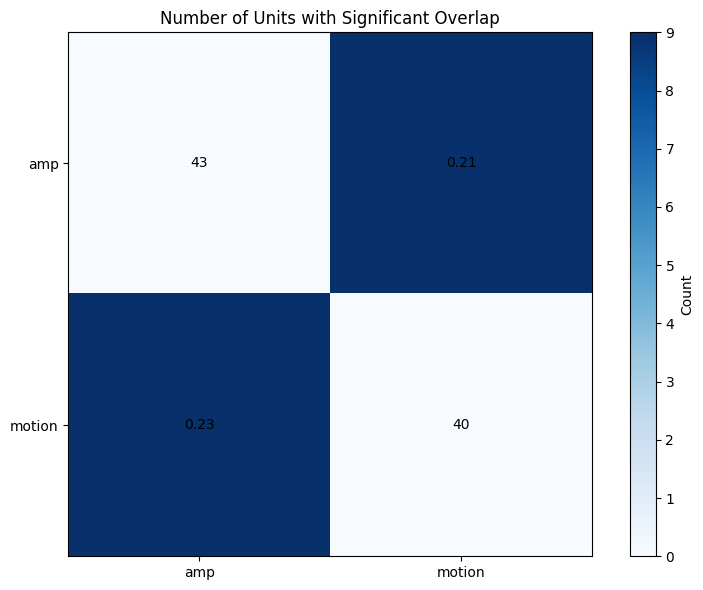

In [68]:
# Regressors to compare
regressors_to_cross = regressors_sup_go
sig_regressors_cross = sig_regressors_go[regressors_to_cross].copy()

# Cross-count matrix
cross_matrix = np.zeros((len(regressors_to_cross), len(regressors_to_cross)), dtype=int)
for ind_x, regressor1 in enumerate(regressors_to_cross):
    for ind_y, regressor2 in enumerate(regressors_to_cross):
        if ind_x == ind_y:
            continue
        cross_matrix[ind_x, ind_y] = len(sig_regressors_cross[
            (sig_regressors_cross[regressor1] == 1) &
            (sig_regressors_cross[regressor2] == 1)
        ])

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cross_matrix, cmap='Blues')

# Add number labels in each cell
for i in range(len(regressors_to_cross)):
    for j in range(len(regressors_to_cross)):
        if i != j:
            ax.text(j, i, f'{cross_matrix[i, j]/np.sum(sig_regressors_go[regressors_to_cross[i]] == 1):.2f}', va='center', ha='center', color='black')
        else:
            ax.text(j, i, f'{np.sum(sig_regressors_go[regressors_to_cross[i]] == 1)}', va='center', ha='center', color='black')

# Axis labels
ax.set_xticks(np.arange(len(regressors_to_cross)))
ax.set_yticks(np.arange(len(regressors_to_cross)))
ax.set_xticklabels(regressors_to_cross)
ax.set_yticklabels(regressors_to_cross)
ax.set_title('Number of Units with Significant Overlap')
plt.colorbar(im, ax=ax, label='Count')
plt.tight_layout()
plt.show()




(0.0, 0.7)

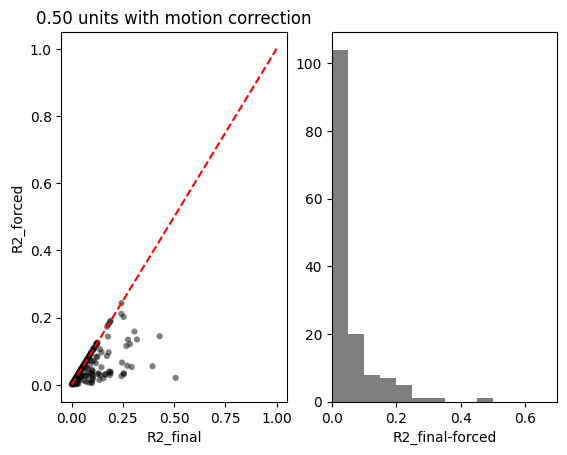

In [69]:
plt.subplot(121)
plt.scatter(sig_regressors_go['R2_final'], sig_regressors_go['R2_forced'], alpha=0.5, color='k', edgecolors='none', s=20)
plt.xlabel('R2_final')
plt.ylabel('R2_forced')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
title = f'{np.sum(sig_regressors_go["R2_final"] > sig_regressors_go["R2_forced"])/len(sig_regressors_go):.2f} units with motion correction'
plt.title(title)

plt.subplot(122)
bins = np.arange(0, 0.7, 0.05)
plt.hist(sig_regressors_go['R2_final']-sig_regressors_go['R2_forced'], bins=bins, alpha=0.5, color='k', edgecolor='none')
plt.xlabel('R2_final-forced')

plt.xlim(0, 0.7)

In [70]:
# sig_regressors_go_abs = sig_regressors_go.copy()
# sig_regressors_go_abs.to_csv(os.path.join(beh_folder, f'sig_regressors_go_abs_{criteria_name}_{align_name}.csv'), index=False)

In [71]:
sig_regressors_abs = pd.read_csv(os.path.join(beh_folder, f'sig_regressors_{criteria_name}_abs.csv'))
sig_regressors_go['R2_final_abs'] = sig_regressors_abs['R2_final']

(-0.5, 0.7)

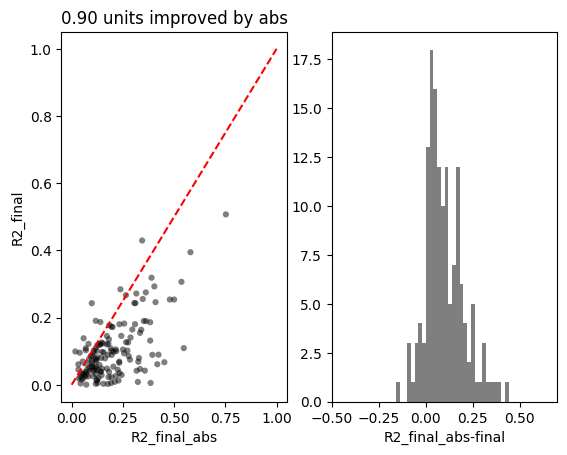

In [72]:
plt.subplot(121)
plt.scatter(sig_regressors_go['R2_final_abs'], sig_regressors_go['R2_final'], alpha=0.5, color='k', edgecolors='none', s=20)
plt.xlabel('R2_final_abs')
plt.ylabel('R2_final')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
title = f'{np.sum(sig_regressors_go["R2_final_abs"] > sig_regressors_go["R2_final"])/len(sig_regressors_go):.2f} units improved by abs'
plt.title(title)

plt.subplot(122)
bins = np.arange(-0.5, 0.7, 0.02)
plt.hist(sig_regressors_go['R2_final_abs']-sig_regressors_go['R2_final'], bins=bins, alpha=0.5, color='k', edgecolor='none')
plt.xlabel('R2_final_abs-final')
plt.xlim(-0.5, 0.7)

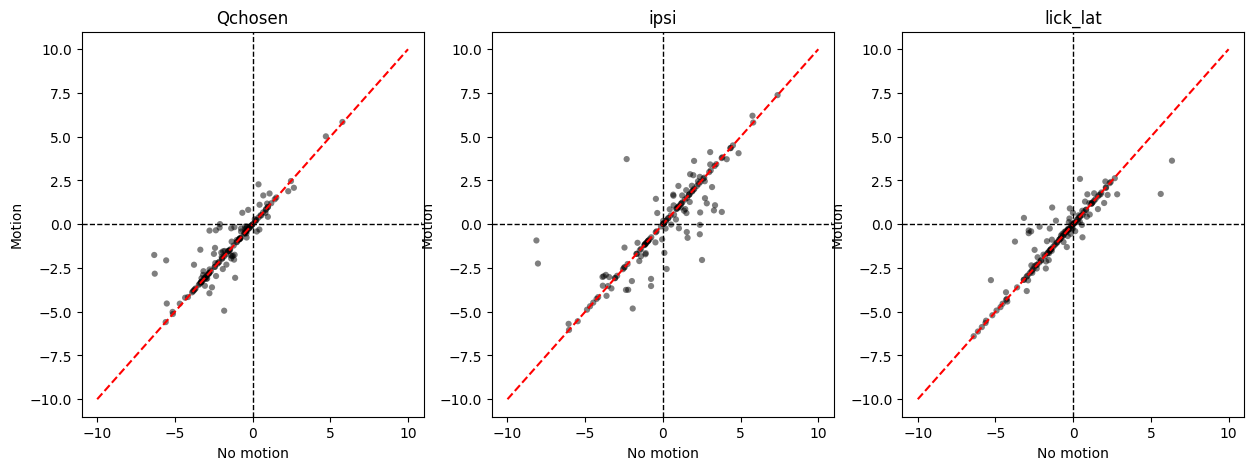

In [80]:
# compare t-values
fig, axes = plt.subplots(1, len(regressors_focus_go), figsize=(15, 5))
for ind, regressor in enumerate(regressors_focus_go):
    axes[ind].scatter(t_regressors_go[regressor], t_regressors_motion_go[regressor], alpha=0.5, color='k', edgecolors='none', s=20)
    axes[ind].plot([-10, 10], [-10, 10], color='r', linestyle='--')
    axes[ind].axhline(0, color='k', linestyle='--', linewidth=1)  # add a horizontal line at y=0
    axes[ind].axvline(0, color='k', linestyle='--', linewidth=1)  # add a vertical line at x=0
    axes[ind].set_xlabel('No motion')
    axes[ind].set_ylabel('Motion')
    axes[ind].set_title(f'{regressor}')


In [74]:
# all_coefsm = np.squeeze(np.array(all_coefs))
# all_Tm = np.squeeze(np.array(all_T))
# all_pm = np.squeeze(np.array(all_p))
all_coefsm = coefs_regressors_motion_go[regressors_focus].astype(dtype=float).values
all_Tm = t_regressors_motion_go[regressors_focus].astype(dtype=float).values
all_pm = p_regressors_motion_go[regressors_focus].astype(dtype=float).values

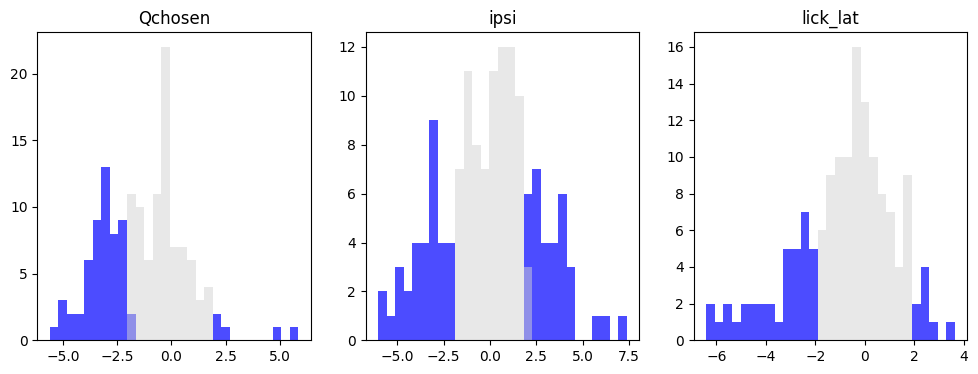

In [75]:
# histogram
fig, axes = plt.subplots(1, len(regressors_focus_go), figsize=(12, 4))
for ind, regressor in enumerate(regressors_focus_go):
    curr_ax = axes[ind]
    curr_T = all_Tm[:, ind] 
    curr_p = all_pm[:, ind]
    bins = np.linspace(np.nanmin(curr_T)-0.01, np.nanmax(curr_T)+0.01, 30)
    curr_ax.hist(curr_T[curr_p<0.05], bins=bins, color='blue', alpha=0.7, edgecolor='none')
    curr_ax.hist(curr_T[curr_p>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
    curr_ax.set_title(f'{regressor}')

NameError: name 'curr_T_outcome' is not defined

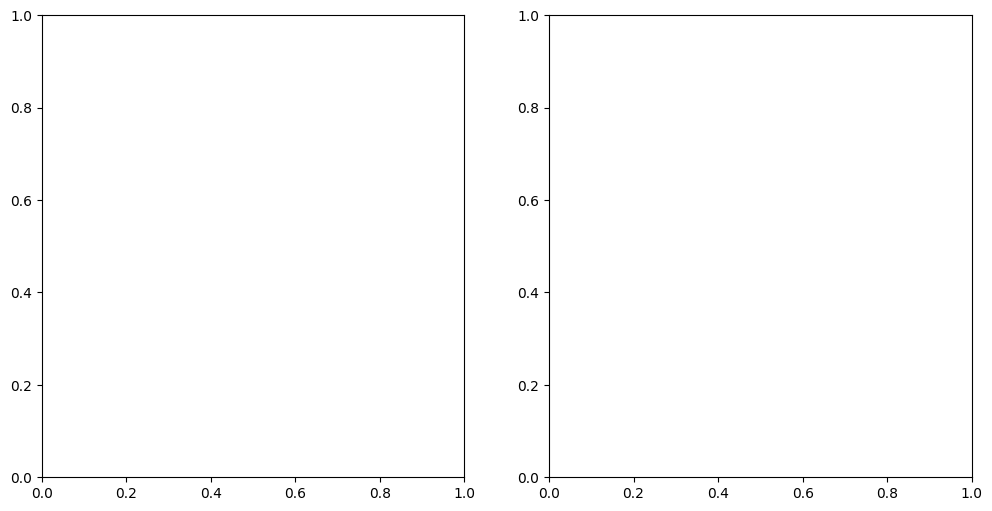

In [77]:
# scatter of outcome and Qchosen coefficients
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(curr_T_outcome[curr_p_outcome<0.05], curr_T_q[curr_p_outcome<0.05], color='none', edgecolors='k', s=30, label = 'outcome p<0.05')
axes[0].scatter(curr_T_outcome[curr_p_outcome>=0.05], curr_T_q[curr_p_outcome>=0.05], color='none', edgecolors='lightgray', s=30, label = 'outcome p>=0.05')
axes[0].set_xlabel('Outcome')
axes[0].set_ylabel('Qchosen')
axes[0].set_title('T-statistics for outcome and Qchosen')
axes[0].axhline(0, color='k', linestyle='--', linewidth=1)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].legend()

# polar
thresh = 1
all_vec = np.column_stack((curr_coefs_outcome[curr_p_outcome<thresh], curr_coefs_q[curr_p_outcome<thresh]))  # combine the coefficients for the reward outcome and Qchosen
# Convert Cartesian coordinates to polar coordinates
theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
# Define histogram edges (bins) from -π to π
edges = np.linspace(-np.pi, np.pi, 4*5)
# Create polar histogram
axes[1] = fig.add_subplot(122, polar=True)
axes[1].hist(theta, bins=edges, color=[0.1, 0.1, 0.1], alpha=0.7, edgecolor='none', density=False)
axes[1].set_yticks([])
axes[1].set_title('Polar histogram')
# plt.suptitle('Outcome and Qchosen coefficients', fontsize=16)
plt.savefig(os.path.join(beh_folder, f'Summary_outcome_Qchosen_coeffs_{criteria_name}.pdf'), bbox_inches='tight')

In [78]:
# make a df from all_Tm, columns correspond to focus regressors 
all_Tm_df = pd.DataFrame(all_Tm, columns=[regressor + '_T' for regressor in regressors_focus])
all_pm_df = pd.DataFrame(all_pm, columns=[regressor + '_p' for regressor in regressors_focus])
all_coefsm_df = pd.DataFrame(all_coefsm, columns=[regressor + '_coef' for regressor in regressors_focus])
model_combined = pd.concat([combined_tagged_units_filtered[['session', 'unit']], all_Tm_df, all_pm_df, all_coefsm_df], axis=1)

In [79]:
model_combined.to_csv(os.path.join(beh_folder, f'model_combined_{criteria_name}.csv'), index=False)